# Overview

小学3年生から高校3年生のクラスで使用するテキストについて<br>
各文章の複雑さを評価するアルゴリズムを構築する。

# Module

In [1]:
import gc
import sys
import scipy
import optuna
import datetime
import warnings
import matplotlib
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from transformers import BertTokenizer,BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Datasets

In [2]:
train = pd.read_csv('../input/commonlitreadabilityprize/train.csv')

print(train.shape)
train.head()

(2834, 6)


,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


学習データ<br>
・id：各文章に紐づいたID<br>
・url_legal：ソースのURL<br>
・license：ソースのライセンス
・excerpt：抜粋した文章<br>
・target：文章読解における難易度<br>
・standard_error：targetの標準誤差

In [3]:
test = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

print(test.shape)
test.head()

(7, 4)


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


テストデータ<br>
・id：各文章に紐づいたID<br>
・url_legal：ソースのURL<br>
・license：ソースのライセンス<br>
・excerpt：抜粋した文章<br>

In [4]:
submission = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')

print(submission.shape)
submission.head()

(7, 2)


,id,target
0,c0f722661,0.0
1,f0953f0a5,0.0
2,0df072751,0.0
3,04caf4e0c,0.0
4,0e63f8bea,0.0


# Analytics

In [5]:
train.nunique()

id                2834
url_legal          667
license             15
excerpt           2834
target            2834
standard_error    2834
dtype: int64

In [6]:
train.isnull().sum()

id                   0
url_legal         2004
license           2004
excerpt              0
target               0
standard_error       0
dtype: int64

In [7]:
train.corr()

,target,standard_error
target,1.000000,-0.085981
standard_error,-0.085981,1.000000


# Visualization

In [8]:
sns.set()

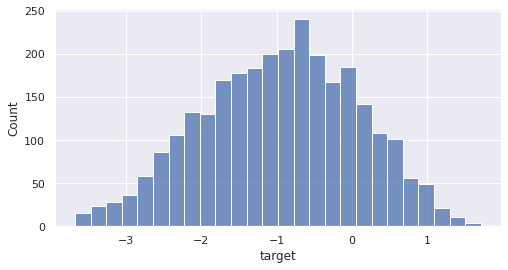

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(train['target'], ax=ax)
plt.show()

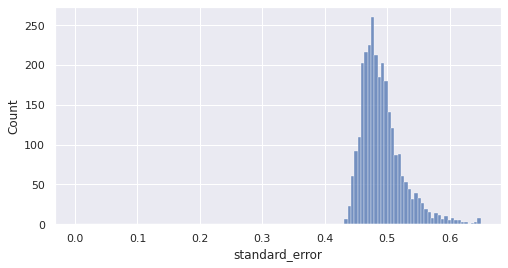

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(train['standard_error'], ax=ax)
plt.show()

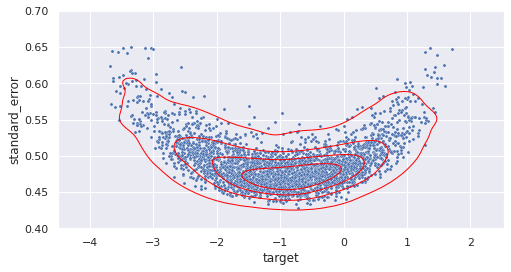

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.scatterplot(x=train['target'], y=train['standard_error'], s=10)
sns.kdeplot(x=train['target'], y=train['standard_error'], levels=5, color='red', linewidths=1)
plt.ylim([0.4, 0.7])
plt.show()

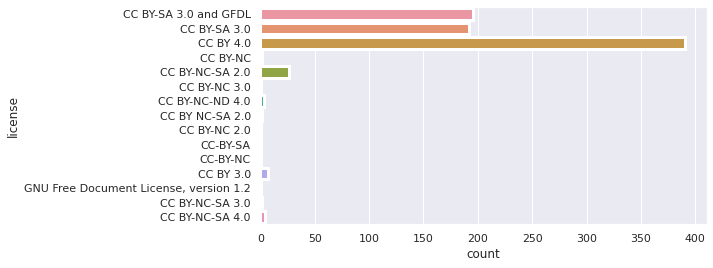

In [12]:
plt.figure(figsize=(8, 4))
sns.countplot(y="license",data=train,linewidth=3)
plt.show()

In [13]:
train['excerpt_len'] = train['excerpt'].apply(lambda x : len(x))
train['excerpt_word_count'] = train['excerpt'].apply(lambda x : len(x.split(' ')))

test['excerpt_len'] = test['excerpt'].apply(lambda x : len(x))
test['excerpt_word_count'] = test['excerpt'].apply(lambda x : len(x.split(' ')))

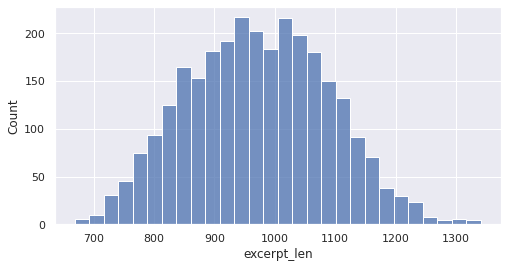

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(train['excerpt_len'], ax=ax)
plt.show()

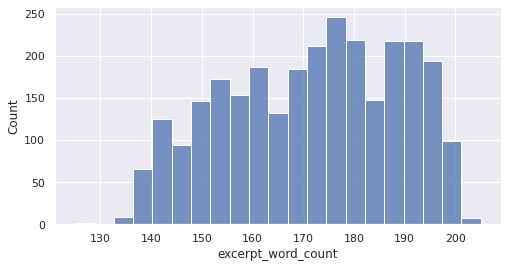

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(train['excerpt_word_count'], ax=ax)
plt.show()

# Preprocess

In [16]:
test

,id,url_legal,license,excerpt,excerpt_len,excerpt_word_count
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...,772,147
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...,967,179
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...,948,168
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...,1144,179
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...,1094,167
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ...",823,148
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...,894,161


In [17]:
target = train['target']
train = train.drop(['url_legal', 'license', 'target', 'standard_error'], axis=1)
test = test.drop(['url_legal', 'license'], axis=1)

In [18]:
train_row = train.shape[0]

In [19]:
X = pd.concat([train, test], axis=0)

print(X.shape)
X.head()

(2841, 4)


,id,excerpt,excerpt_len,excerpt_word_count
0,c12129c31,When the young people returned to the ballroom...,992,174
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",937,164
2,b69ac6792,"As Roger had predicted, the snow departed as q...",908,162
3,dd1000b26,And outside before the palace a great garden w...,909,163
4,37c1b32fb,Once upon a time there were Three Bears who li...,723,147


In [20]:
cv = CountVectorizer()

id_data = cv.fit_transform(X['id'])
id_data

<2841x2841 sparse matrix of type '<class 'numpy.int64'>'
	with 2841 stored elements in Compressed Sparse Row format>

In [21]:
tv = TfidfVectorizer()

excerpt_data = tv.fit_transform(X['excerpt'])
excerpt_data

<2841x26867 sparse matrix of type '<class 'numpy.float64'>'
	with 294991 stored elements in Compressed Sparse Row format>

In [22]:
len_data = scipy.sparse.csr_matrix(pd.get_dummies(X['excerpt_len'], sparse = True).values)
len_data

<2841x522 sparse matrix of type '<class 'numpy.uint8'>'
	with 2841 stored elements in Compressed Sparse Row format>

In [23]:
count_data = scipy.sparse.csr_matrix(pd.get_dummies(X['excerpt_word_count'], sparse = True).values)
count_data

<2841x72 sparse matrix of type '<class 'numpy.uint8'>'
	with 2841 stored elements in Compressed Sparse Row format>

In [24]:
X_sparse = scipy.sparse.hstack((id_data, excerpt_data, len_data, count_data)).tocsr()
X_sparse

<2841x30302 sparse matrix of type '<class 'numpy.float64'>'
	with 303514 stored elements in Compressed Sparse Row format>

In [25]:
train = X_sparse[:train_row]
test = X_sparse[train_row:]

In [26]:
del X, X_sparse, id_data, excerpt_data, len_data, count_data, train_row, cv, tv
gc.collect()

26734

# Modeling

In [27]:
'''
X_tr, X_val, y_tr, y_val = train_test_split(train, target, test_size=0.2, random_state=666)

def create_model(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 30)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    
    model = lgb.LGBMRegressor(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=666)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rsme = np.sqrt(mean_squared_error(y_pred, y_val))
    return rsme

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)
params = study.best_params
print(params)
'''

"\nX_tr, X_val, y_tr, y_val = train_test_split(train, target, test_size=0.2, random_state=666)\n\ndef create_model(trial):\n    num_leaves = trial.suggest_int('num_leaves', 2, 30)\n    n_estimators = trial.suggest_int('n_estimators', 50, 300)\n    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)\n    max_depth = trial.suggest_int('max_depth', 2, 10)\n    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)\n    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)\n    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)\n    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)\n    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)\n    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)\n    \n    model = lgb.LGBMRegressor(\n        num_leaves=num_leaves,\n        n_estimators=n_estimators,\n        learning_rate

In [28]:
params = {'num_leaves': 12,
          'n_estimators': 299,
          'learning_rate': 0.12976125116082543,
          'max_depth': 10,
          'min_child_samples': 851,
          'min_data_in_leaf': 5,
          'bagging_freq': 2,
          'bagging_fraction': 0.7828973350680036,
          'feature_fraction': 0.21210793556709107,
          'subsample': 0.9874364347245423,
          'colsample_bytree': 0.5281379841297079,
          'random_state': 666}

In [29]:
cls = lgb.LGBMRegressor(**params)
cls.fit(train, target)

[LightGBM] [Warning] bagging_fraction is set=0.7828973350680036, subsample=0.9874364347245423 will be ignored. Current value: bagging_fraction=0.7828973350680036
[LightGBM] [Warning] feature_fraction is set=0.21210793556709107, colsample_bytree=0.5281379841297079 will be ignored. Current value: feature_fraction=0.21210793556709107
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=851 will be ignored. Current value: min_data_in_leaf=5


LGBMRegressor(bagging_fraction=0.7828973350680036, bagging_freq=2,
              colsample_bytree=0.5281379841297079,
              feature_fraction=0.21210793556709107,
              learning_rate=0.12976125116082543, max_depth=10,
              min_child_samples=851, min_data_in_leaf=5, n_estimators=299,
              num_leaves=12, random_state=666, subsample=0.9874364347245423)

In [30]:
del train, target, params
gc.collect()

125

# Submit

In [31]:
prediction = cls.predict(test)

In [32]:
del test
gc.collect()

48

In [33]:
submit = pd.DataFrame(submission['id'], columns=['id'])
submit['target'] = prediction

submit.head()

,id,target
0,c0f722661,-1.680550
1,f0953f0a5,-0.320672
2,0df072751,-0.331057
3,04caf4e0c,-1.729285
4,0e63f8bea,-1.511802


In [34]:
submit.to_csv('./submission.csv', index=False)